In [57]:
import pandas as pd 
import numpy as np
import seaborn as sns
from acquire import get_connection, new_telco_churn_data, get_telco_churn_data
from env import username, host, password

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from acquire import get_connection, new_telco_churn_data, get_telco_churn_data
from prepare import num_distributions, clean_telco_churn, telco_churn_split, prep_telco_churn
from explore import get_metrics_binary
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from math import sqrt
from scipy import stats

-bring in clean data

## Decision Tree

In [30]:
df = get_telco_churn_data()


In [31]:
df = clean_telco_churn(df)

In [121]:
df.churn.value_counts()

0    5174
1    1869
Name: churn, dtype: int64

In [61]:
train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.churn)
train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.churn)

In [62]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3943, 28)
validate -> (1691, 28)
test -> (1409, 28)


In [65]:
def split_data(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames; stratify on survived.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.churn)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123, 
                                       stratify=train_validate.churn)
    return train, validate, test

In [66]:
train, validate, test = split_data(df)

In [67]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (3943, 28)
validate -> (1691, 28)
test -> (1409, 28)


In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5707 to 6864
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        3943 non-null   object 
 1   senior_citizen     3943 non-null   int64  
 2   partner            3943 non-null   int64  
 3   dependents         3943 non-null   int64  
 4   tenure             3943 non-null   int64  
 5   phone_service      3943 non-null   int64  
 6   multiple_lines     3943 non-null   int64  
 7   online_security    3943 non-null   int64  
 8   online_backup      3943 non-null   int64  
 9   device_protection  3943 non-null   int64  
 10  tech_support       3943 non-null   int64  
 11  streaming_tv       3943 non-null   int64  
 12  streaming_movies   3943 non-null   int64  
 13  paperless_billing  3943 non-null   int64  
 14  monthly_charges    3943 non-null   float64
 15  total_charges      3943 non-null   float64
 16  churn              39

In [69]:
x_col = ['fiber_optic', 'electronic_check', 'tenure', 'one_year', 'monthly']
y_col = 'churn'

In [70]:
train.shape, validate.shape, test.shape

((3943, 28), (1691, 28), (1409, 28))

In [71]:
train.head()

,customer_id,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,dsl,fiber_optic,no_internet,monthly,one_year,two_year,bank_transfer,credit_card,electronic_check,mailed_check
5707,5605-XNWEN,1,1,0,72,1,1,0,0,0,...,0,0,1,0,0,1,1,0,0,0
4471,4355-CVPVS,0,1,1,56,1,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
4994,3915-ODIYG,1,0,0,60,1,1,1,1,0,...,1,0,0,0,1,0,0,0,1,0
3458,6575-SUVOI,1,1,0,25,1,1,1,0,0,...,1,0,0,1,0,0,0,1,0,0
3818,9504-DSHWM,0,0,0,20,1,1,1,0,0,...,1,0,0,1,0,0,1,0,0,0


In [72]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 


X_train, y_train = train[x_col], train[y_col]

X_validate, y_validate = validate[x_col], validate[y_col]

X_test, y_test = test[x_col], test[y_col]

In [73]:
X_train.head()

,fiber_optic,electronic_check,tenure,one_year,monthly
5707,0,0,72,0,0
4471,1,0,56,1,0
4994,0,1,60,1,0
3458,0,0,25,0,1
3818,0,0,20,0,1


In [74]:
y_train.value_counts()

0    2897
1    1046
Name: churn, dtype: int64

In [75]:
train['baseline_prediction'] = 0 #because I'm predicting more people did churn
round(accuracy_score(train.churn, train.baseline_prediction),2)

0.73

In [76]:
baseline_score = round(accuracy_score(train.churn, train.baseline_prediction),2)
print(f'Our baseline score is {baseline_score}')

Our baseline score is 0.73


In [77]:
# Create the object, 15 nodes and max depth of 2. 
tree1 = DecisionTreeClassifier(max_leaf_nodes=15, max_depth=5, random_state=123)

In [78]:
# Fit the model
tree1 = tree1.fit(X_train, y_train)

In [79]:
# percentages indicate our data is not over fit

print(f'training score: {treeA.score(X_train, y_train):.2%}')
print(f'validate score: {treeA.score(X_validate, y_validate):.2%}')

training score: 79.99%
validate score: 78.30%


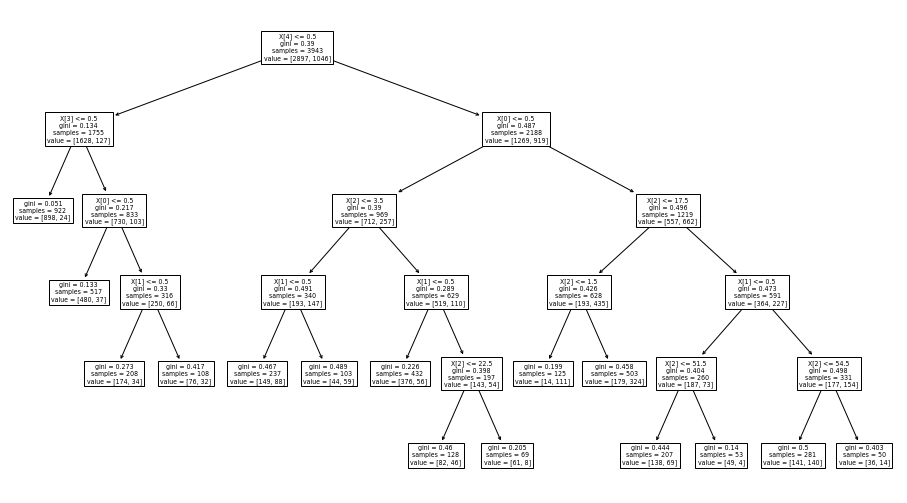

In [80]:
# show the outcome of our decision tree
plt.figure(figsize=(16,9))
plot_tree(tree1)
plt.show()

In [81]:
# make prediction on train obeservations

y_pred = treeA.predict(X_train)
y_pred[0:5]

array([0, 0, 0, 0, 0])

In [82]:
#Estimate Probability
y_pred_proba = tree1.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.97396963, 0.02603037],
       [0.83653846, 0.16346154],
       [0.92843327, 0.07156673],
       [0.87037037, 0.12962963],
       [0.87037037, 0.12962963]])

In [83]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(tree1.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


In [84]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2897
           1       0.68      0.47      0.56      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.70      0.71      3943
weighted avg       0.79      0.80      0.79      3943



In [85]:
# learn how well the model does on new data
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(tree1.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.78


In [86]:
y_pred = tree1.predict(X_validate)
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1242
           1       0.63      0.45      0.52       449

    accuracy                           0.78      1691
   macro avg       0.72      0.68      0.69      1691
weighted avg       0.77      0.78      0.77      1691



In [87]:
#Model 2 with max_depth set to 2

#Create the object
tree2 = DecisionTreeClassifier(max_depth= 3, random_state=254,  max_leaf_nodes=10)

#specify features we're using
x_col = ['fiber_optic', 'electronic_check', 'tenure', 'one_year', 'monthly']
y_col = 'churn'
#Fit it
tree2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=10, random_state=254)

In [88]:
print(f'training score: {tree2.score(X_train, y_train):.2%}')
print(f'validate score: {tree2.score(X_validate, y_validate):.2%}')

training score: 79.61%
validate score: 78.18%


In [117]:
#Model 3 with max_depth set to 2

#Create the object
tree3 = DecisionTreeClassifier(max_depth= 10, random_state=123,  max_leaf_nodes=15)

#specify features we're using
x_col = ['fiber_optic', 'electronic_check', 'tenure', 'one_year', 'monthly']
y_col = 'churn'
#Fit it
tree3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_leaf_nodes=15, random_state=123)

In [118]:
print(f'training score: {tree3.score(X_train, y_train):.2%}')
print(f'validate score: {tree3.score(X_validate, y_validate):.2%}')

training score: 79.99%
validate score: 78.30%


## KNN

In [102]:
#setting up and fitting my KNN model 
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [103]:
#let's see the training and validate scores
print(f'training score: {knn.score(X_train, y_train):.2%}')
print(f'validate score: {knn.score(X_validate, y_validate):.2%}')

training score: 79.61%
validate score: 76.82%


In [116]:
#classification report
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1242
           1       0.63      0.45      0.52       449

    accuracy                           0.78      1691
   macro avg       0.72      0.68      0.69      1691
weighted avg       0.77      0.78      0.77      1691

